## Download DICOM images

We will download the DICOM images and save them as .npz files

A total of 900 patients data (125 GB of DICOM) was downloaded and the final size of the saved .npz files were only 74GB

The code loops over 10 patients at a time, downloads their CT images, converts them into .npz and cleans up the directory

The data is saved in a new disk (100 GB) mounted into /mnt/disks/data

In [ ]:
#### Install the pidicom libraries

In [1]:
#!git clone https://github.com/pieper/dicomsort.git
!pip install pydicom
!pip install pylidc
#!python dicomsort/dicomsort.py --help

In [2]:
import pylidc as pl
from pylidc.utils import consensus
import pydicom as dicom
from skimage.measure import find_contours
import numpy as np
import matplotlib.pyplot as plt

In [3]:
pl.query(pl.Scan).count()
pid = 'LIDC-IDRI-0069'#'LIDC-IDRI-0001'
scan = pl.query(pl.Scan).filter(pl.Scan.patient_id == pid).first()
scan.study_instance_uid

'1.3.6.1.4.1.14519.5.2.1.6279.6001.303241414168367763244410429787'

In [4]:
!pip install google-cloud-bigquery
!pip install --upgrade google-auth-oauthlib
!pip install --upgrade 'google-cloud-bigquery[bqstorage,pandas]'

     |████████████████████████████████| 202 kB 10.2 MB/s eta 0:00:01
     |████████████████████████████████| 3.9 MB 69.8 MB/s eta 0:00:01
     |████████████████████████████████| 43 kB 3.0 MB/s  eta 0:00:01
     |████████████████████████████████| 92 kB 679 kB/s  eta 0:00:01
     |████████████████████████████████| 75 kB 7.5 MB/s  eta 0:00:01
  Attempting uninstall: grpcio
    Found existing installation: grpcio 1.34.1
    Uninstalling grpcio-1.34.1:
      Successfully uninstalled grpcio-1.34.1
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
tensorflow 2.5.0+nv requires grpcio~=1.34.0, but you have grpcio 1.41.0 which is incompatible.
  Attempting uninstall: google-auth-oauthlib
    Found existing installation: google-auth-oauthlib 0.4.5
    Uninstalling google-auth-oauthlib-0.4.5:
      Successfully uninstalled google-auth-oauthlib-0.4.5
     |███████████████████

In [5]:
from google_auth_oauthlib import flow

# TODO: Uncomment the line below to set the `launch_browser` variable.
launch_browser = False
#
# The `launch_browser` boolean variable indicates if a local server is used
# as the callback URL in the auth flow. A value of `True` is recommended,
# but a local server does not work if accessing the application remotely,
# such as over SSH or from a remote Jupyter notebook.

appflow = flow.InstalledAppFlow.from_client_secrets_file(
    "client_secret_desktop.json", scopes=["https://www.googleapis.com/auth/bigquery"]
)

if launch_browser:
    appflow.run_local_server()
else:
    appflow.run_console()

credentials = appflow.credentials

Please visit this URL to authorize this application: https://accounts.google.com/o/oauth2/auth?response_type=code&client_id=354066013909-il5lh54dbass54iv45m7thff0uuefjar.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fbigquery&state=akdGBwyOYA5rylbgvRxduNOlMR3nTf&prompt=consent&access_type=offline


Enter the authorization code:  4/1AX4XfWiyUlOLs_W9lVGBHFymyid_DO13ZkVHPtduQJD4pYUDpYfKbqrPhIk


In [7]:
%load_ext google.cloud.bigquery

In [10]:
from google.cloud.bigquery import magics
magics.context.credentials = credentials

In [12]:
myProjectID = "idc-external-012"

In [13]:
%%bigquery CT_series --project=$myProjectID 

WITH
  all_lidc_ct_series AS (
  SELECT
    DISTINCT(SeriesInstanceUID),
    StudyInstanceUID,  
    PatientID,
    SliceThickness,
    ARRAY_TO_STRING(PixelSpacing,"/") as pixelspa 
  FROM
    `canceridc-data.idc_views.dicom_all`
  WHERE
    Modality = "CT"
    AND collection_id = "lidc_idri")
SELECT PatientID,SliceThickness,pixelspa,StudyInstanceUID,SeriesInstanceUID FROM
  all_lidc_ct_series
ORDER BY
  PatientID

Downloading: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1018/1018 [00:01<00:00, 699.48rows/s]


In [27]:
total_patients = len(np.unique(CT_series['PatientID']))
chosen_patients = len(np.unique(CT_series[(CT_series["SliceThickness"].astype(float)>=1.0)]['PatientID']))
print("Choosing patients with slice thickness > 1.0")
print("Total patients is {} and chosen patients are {}".format(total_patients, chosen_patients))

Choosing patients with slice thickness > 1.0
Total patients is 1010 and chosen patients are 971


In [30]:
import pandas as pd
# s_1,s_2,s_3 = 5,5,5
# ct_series_1 = CT_series[CT_series["SliceThickness"].astype(float)==1.0]
# ct_series_2 = CT_series[CT_series["SliceThickness"].astype(float)==2.0]
# ct_series_3 = CT_series[CT_series["SliceThickness"].astype(float)==3.0]
# ct_series_HR = pd.concat([ct_series_1[:s_1],ct_series_2[:s_2],ct_series_3[:s_3]])
ct_series_HR = CT_series[(CT_series["SliceThickness"].astype(float)>=1.0)]
print("Shape of the raw dataset is {}".format(ct_series_HR.shape))

Shape of the raw dataset is (979, 5)


In [31]:
to_download = []
base_gs_uri = 'gs://idc-tcia-lidc-idri/dicom/'

for i in range(ct_series_HR.shape[0]):
    to_download.append(base_gs_uri + ct_series_HR.iloc[i]['StudyInstanceUID'] + '/' + ct_series_HR.iloc[i]['SeriesInstanceUID'])

manifest_df = pd.DataFrame({"gcs":to_download},columns=["gcs"])

In [35]:
manifest_df.to_csv("gcs_paths_all.txt",header=False, index=False)
!head gcs_paths_all.txt

gs://idc-tcia-lidc-idri/dicom/1.3.6.1.4.1.14519.5.2.1.6279.6001.298806137288633453246975630178/1.3.6.1.4.1.14519.5.2.1.6279.6001.179049373636438705059720603192
gs://idc-tcia-lidc-idri/dicom/1.3.6.1.4.1.14519.5.2.1.6279.6001.490157381160200744295382098329/1.3.6.1.4.1.14519.5.2.1.6279.6001.619372068417051974713149104919
gs://idc-tcia-lidc-idri/dicom/1.3.6.1.4.1.14519.5.2.1.6279.6001.101370605276577556143013894866/1.3.6.1.4.1.14519.5.2.1.6279.6001.170706757615202213033480003264
gs://idc-tcia-lidc-idri/dicom/1.3.6.1.4.1.14519.5.2.1.6279.6001.191425307197546732281885591780/1.3.6.1.4.1.14519.5.2.1.6279.6001.323541312620128092852212458228
gs://idc-tcia-lidc-idri/dicom/1.3.6.1.4.1.14519.5.2.1.6279.6001.190188259083742759886805142125/1.3.6.1.4.1.14519.5.2.1.6279.6001.129007566048223160327836686225
gs://idc-tcia-lidc-idri/dicom/1.3.6.1.4.1.14519.5.2.1.6279.6001.324680252006411183918098592500/1.3.6.1.4.1.14519.5.2.1.6279.6001.132817748896065918417924920957
gs://idc-tcia-lidc-idri/dicom/1.3.6.1.4.

In [36]:
!pip install gsutil

     |████████████████████████████████| 2.9 MB 8.1 MB/s eta 0:00:01
     |████████████████████████████████| 89 kB 11.9 MB/s eta 0:00:01
     |████████████████████████████████| 135 kB 69.0 MB/s eta 0:00:01
     |████████████████████████████████| 95 kB 7.3 MB/s  eta 0:00:01
     |████████████████████████████████| 55 kB 6.1 MB/s  eta 0:00:01
     |████████████████████████████████| 1.4 MB 60.9 MB/s eta 0:00:01
     |████████████████████████████████| 98 kB 13.1 MB/s eta 0:00:01
     |████████████████████████████████| 3.5 MB 56.9 MB/s eta 0:00:01
  Created wheel for gsutil: filename=gsutil-5.3-py3-none-any.whl size=3713522 sha256=973d4ed8b821eeafef429f6f172d37380d57693d758f99108154346f255ecbd6
  Stored in directory: /root/.cache/pip/wheels/b2/4a/2c/1b8db4719f842155e5b945c0a76af939519c6d6d5da7fc4019
  Created wheel for crcmod: filename=crcmod-1.7-cp38-cp38-linux_x86_64.whl size=36033 sha256=2f931477bbd7c382558520699f729b10883f3213911e93b8613eedcda2b36182
  Stored in directory: /root/.cache/pi

Download 100 patients at a time and convert the images to .npz files

In [114]:
!rm -rf /data/temp/gcsfiles/
!rm -rf /data/temp/sorted_gcsfiles/

In [134]:
import os
# this directory will be created in the downloader but never deletedn entirely, only contents would be cleared
data_folder = '/data/temp/sorted_gcsfiles/'

In [135]:
#f = open ('.pylidcrc','w')            #For GCP
f = open ('/root/.pylidcrc','w')    #For Colab
f.write('[dicom]'+'\n')
f.write('path =' + data_folder +'\n')
f.write('warn = True')
f.close()

In [138]:
from tqdm import tqdm

In [122]:
patient_list = os.listdir(data_folder)

Current patient ID = LIDC-IDRI-0007
Loading dicom files ... This may take a moment.


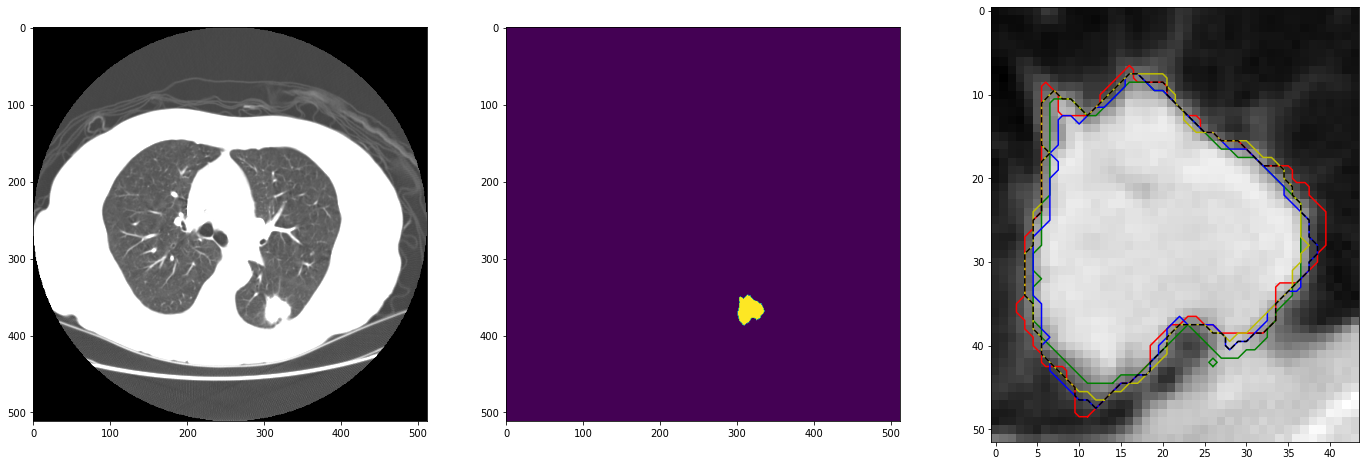

In [123]:
%matplotlib inline

patient_select = 0
print ("Current patient ID =", patient_list[patient_select])

scan = pl.query(pl.Scan).filter(pl.Scan.patient_id.in_(patient_list))
nodules_annotation = scan[patient_select].cluster_annotations()
vol = scan[patient_select].to_volume()

cmask_CT = []
cbbox_CT = []
masks_CT = []
for nodule_idx, nodule in enumerate(nodules_annotation):
    cmask, cbbox, masks = consensus(nodule)
    cmask_CT.append(cmask)
    cbbox_CT.append(cbbox)
    masks_CT.append(masks)   

nodule_num = len(cmask_CT)
plt.figure(figsize=(8*3,8*nodule_num))
for i in range(nodule_num):
    cmask = cmask_CT[i]
    cbbox = cbbox_CT[i]
    masks = masks_CT[i]
    k = int(0.5*(cbbox[2].stop - cbbox[2].start))
    k_slice = k + cbbox[2].start
    plt.subplot(nodule_num,3,1+i*3)
    plt.imshow(vol[:,:,k_slice],cmap='gray')
    plt.clim(vmin=-1350,vmax=-150)
    
    plt.subplot(nodule_num,3,2+i*3)
    CT_mask = np.zeros_like(vol)
    CT_mask[cbbox] = cmask
    plt.imshow(CT_mask[:,:,k_slice])

    plt.subplot(nodule_num,3,3+i*3)
    plt.imshow(vol[cbbox][:,:,k],cmap='gray')
    # Plot the annotation contours for the kth slice.
    colors = ['r', 'g', 'b', 'y']
    for j in range(len(masks)):
        for c in find_contours(masks[j][:,:,k].astype(float), 0.5):
            label = "Annotation %d" % (j+1)
            plt.plot(c[:,1], c[:,0], colors[j], label=label)

    # Plot the 50% consensus contour for the kth slice.
    for c in find_contours(cmask[:,:,k].astype(float), 0.5):
        plt.plot(c[:,1], c[:,0], '--k', label='50% Consensus')

In [128]:
from PIL import Image
import contextlib

def save_patient_images_and_masks(patient_id, root_dir='/data/train'):
    scan = pl.query(pl.Scan).filter(pl.Scan.patient_id.in_([patient_id]))[0]
    nodules_annotation = scan.cluster_annotations()
    with contextlib.redirect_stdout(None):
        vol = scan.to_volume()

    cmask_CT = []
    cbbox_CT = []
    masks_CT = []
    for nodule_idx, nodule in enumerate(nodules_annotation):
        cmask, cbbox, masks = consensus(nodule)
        cmask_CT.append(cmask)
        cbbox_CT.append(cbbox)
        masks_CT.append(masks)   

    CT_mask = np.zeros_like(vol)    
    nodule_num = len(cmask_CT)

    for i in range(nodule_num):
        cmask = cmask_CT[i]
        cbbox = cbbox_CT[i]
        masks = masks_CT[i]    
        CT_mask[cbbox] += cmask

    for slice_id in range(vol.shape[2]):
        image = vol[:,:,slice_id]
        mask = CT_mask[:,:,slice_id]
        image_file_name = root_dir + "/images/" + "img" + "_" + str(patient_id) + "_" + str(slice_id) + ".npz"
        mask_file_name = root_dir + "/masks/" + "mask" + "_" + str(patient_id) + "_" + str(slice_id) + ".npz"
        np.savez_compressed(image_file_name, image)
        np.savez_compressed(mask_file_name, mask)

In [152]:
root_dir = '/data/all/train'
def patient_data_as_npz_files():
    #get patient list
    patient_list = os.listdir(data_folder)
    if not os.path.exists(root_dir):
        print("Creating directory {}".format(root_dir))
        os.makedirs(root_dir)
    if not os.path.exists(root_dir + "/images/"):
        print("Creating directory {}".format(root_dir + "/images/"))
        os.makedirs(root_dir + "/images/")
    if not os.path.exists(root_dir + "/masks/"):
        print("Creating directory {}".format(root_dir + "/masks/"))
        os.makedirs(root_dir + "/masks/")
    print("Saving patient .npz files to {}".format(root_dir))
    for i in tqdm(range(len(patient_list))):
        try:
            save_patient_images_and_masks(patient_list[i], root_dir)
        except:
            print("Error getting DICOM files for patient {}, skipping".format(patient_list[i]))

In [142]:
# clean start
!rm -rf /data/temp/gcsfiles/
!rm -rf /data/temp/sorted_gcsfiles/

In [157]:
manifest_df[51:]

,gcs
51,gs://idc-tcia-lidc-idri/dicom/1.3.6.1.4.1.1451...
52,gs://idc-tcia-lidc-idri/dicom/1.3.6.1.4.1.1451...
53,gs://idc-tcia-lidc-idri/dicom/1.3.6.1.4.1.1451...
54,gs://idc-tcia-lidc-idri/dicom/1.3.6.1.4.1.1451...
55,gs://idc-tcia-lidc-idri/dicom/1.3.6.1.4.1.1451...
...,...
974,gs://idc-tcia-lidc-idri/dicom/1.3.6.1.4.1.1451...
975,gs://idc-tcia-lidc-idri/dicom/1.3.6.1.4.1.1451...
976,gs://idc-tcia-lidc-idri/dicom/1.3.6.1.4.1.1451...
977,gs://idc-tcia-lidc-idri/dicom/1.3.6.1.4.1.1451...


In [158]:
import os, shutil
import glob
download_dir = '/data/temp/gcsfiles/'
sorted_dir = '/data/temp/sorted_gcsfiles/'
if not os.path.exists(download_dir):
    print("Creating directory {}".format(download_dir))
    os.makedirs(download_dir)
else:
    print("Directory {} exists".format(download_dir))

if not os.path.exists(sorted_dir):
    print("Creating directory {}".format(sorted_dir))
    os.makedirs(sorted_dir)
else:
    print("Directory {} exists".format(sorted_dir))

max_patients = 100 #change this later, for testing .npz files etc.   
# set start from an index
start_patient = 50
#wrong, fix it, need to use positions not i
for i in tqdm(range(manifest_df[start_patient+1:].shape[0])):
    #wrong, fix it, need to use positions not i
    url = manifest_df.iloc[i].gcs
    download_command = "gsutil -u {} -m cp -r {} {} >/dev/null 2>&1".format(myProjectID, url, download_dir)
    os.system(download_command)
    if (i > 1) and (i % 10 == 0): # got 10 patients
       # sort the images
       # !python dicomsort/dicomsort.py -u downloaded_cohort_3 cohort_sorted_3/%PatientID/%StudyInstanceUID/%SeriesInstanceUID/%SOPInstanceUID.dcm
        sort_command = "python dicomsort/dicomsort.py -u {} {}/%PatientID/%StudyInstanceUID/%SeriesInstanceUID/%SOPInstanceUID.dcm".format(download_dir, sorted_dir)
        os.system(sort_command)
        #todo: remove the download_dir contents
        print("Cleaning up downloaded DICOM files...")
        files = glob.glob(download_dir + "/*")
        for i in tqdm(range(len(files))):
            if os.path.isdir(files[i]):
                shutil.rmtree(files[i])
        print("Saving patient data as .npz file...")
        patient_data_as_npz_files()
        #todo: remove the sorted_dir contents
        print("Cleaning up sorted DICOM files...")
        files = glob.glob(sorted_dir + "/*")
        for i in tqdm(range(len(files))):
            if os.path.isdir(files[i]):
                shutil.rmtree(files[i])

Directory /data/temp/gcsfiles/ exists
Directory /data/temp/sorted_gcsfiles/ exists


100%|██████████| 1980/1980 [00:03<00:00, 501.99it/s]                                                                                    | 10/928 [00:39<1:02:53,  4.11s/it]


Files sorted
Cleaning up downloaded DICOM files...



100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 11/11 [00:00<00:00, 59.43it/s]


Saving patient data as .npz file...
Saving patient .npz files to /data/all/train



100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 11/11 [01:56<00:00, 10.60s/it]


Cleaning up sorted DICOM files...



100%|██████████| 1761/1761 [00:03<00:00, 500.44it/s]                                                                                    | 20/928 [03:15<1:22:31,  5.45s/it]


Files sorted
Cleaning up downloaded DICOM files...



100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 66.40it/s]


Saving patient data as .npz file...
Saving patient .npz files to /data/all/train



100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [01:43<00:00, 10.38s/it]


Cleaning up sorted DICOM files...



100%|██████████| 1724/1724 [00:03<00:00, 495.80it/s]                                                                                    | 30/928 [05:38<1:13:12,  4.89s/it]


Files sorted
Cleaning up downloaded DICOM files...



100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 68.33it/s]


Saving patient data as .npz file...
Saving patient .npz files to /data/all/train



100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [01:36<00:00,  9.66s/it]


Error getting DICOM files for patient LIDC-IDRI-0030, skipping
Cleaning up sorted DICOM files...



100%|██████████| 1882/1882 [00:03<00:00, 490.99it/s]                                                                                    | 40/928 [08:01<1:21:37,  5.51s/it]


Files sorted
Cleaning up downloaded DICOM files...



100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 52.97it/s]


Saving patient data as .npz file...
Saving patient .npz files to /data/all/train



100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [01:49<00:00, 10.95s/it]


Cleaning up sorted DICOM files...



100%|██████████| 1479/1479 [00:02<00:00, 508.11it/s]                                                                                    | 50/928 [10:27<1:09:54,  4.78s/it]


Files sorted
Cleaning up downloaded DICOM files...



100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 57.18it/s]


Saving patient data as .npz file...
Saving patient .npz files to /data/all/train



100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [01:29<00:00,  8.94s/it]


Cleaning up sorted DICOM files...



100%|██████████| 1649/1649 [00:03<00:00, 466.29it/s]                                                                                    | 60/928 [12:37<1:06:26,  4.59s/it]


Files sorted
Cleaning up downloaded DICOM files...



100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 71.81it/s]


Saving patient data as .npz file...
Saving patient .npz files to /data/all/train



 60%|█████████████████████████████████████████████████████████████████████████████████                                                      | 6/10 [01:00<00:33,  8.47s/it]

Failed to reduce all groups to <= 4 Annotations.
Some nodules may be close and must be grouped manually.



100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [01:38<00:00,  9.81s/it]


Cleaning up sorted DICOM files...



100%|██████████| 1960/1960 [00:03<00:00, 512.12it/s]                                                                                    | 70/928 [14:55<1:13:35,  5.15s/it]


Files sorted
Cleaning up downloaded DICOM files...



100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 52.47it/s]


Saving patient data as .npz file...
Saving patient .npz files to /data/all/train



100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [01:52<00:00, 11.24s/it]


Cleaning up sorted DICOM files...



100%|██████████| 1749/1749 [00:03<00:00, 511.40it/s]                                                                                    | 80/928 [17:33<1:18:13,  5.53s/it]


Files sorted
Cleaning up downloaded DICOM files...



100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 66.35it/s]


Saving patient data as .npz file...
Saving patient .npz files to /data/all/train



100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [01:37<00:00,  9.76s/it]


Cleaning up sorted DICOM files...



100%|██████████| 1987/1987 [00:03<00:00, 506.36it/s]                                                                                    | 90/928 [20:05<1:13:46,  5.28s/it]


Files sorted
Cleaning up downloaded DICOM files...



100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 49.15it/s]


Saving patient data as .npz file...
Saving patient .npz files to /data/all/train



 60%|█████████████████████████████████████████████████████████████████████████████████                                                      | 6/10 [01:16<00:53, 13.39s/it]

Failed to reduce all groups to <= 4 Annotations.
Some nodules may be close and must be grouped manually.



100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [01:59<00:00, 11.91s/it]


Cleaning up sorted DICOM files...



100%|██████████| 2085/2085 [00:04<00:00, 492.56it/s]                                                                                   | 100/928 [22:51<1:16:59,  5.58s/it]


Files sorted
Cleaning up downloaded DICOM files...



100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 59.49it/s]


Saving patient data as .npz file...
Saving patient .npz files to /data/all/train



100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [02:09<00:00, 12.93s/it]


Cleaning up sorted DICOM files...



100%|██████████| 1411/1411 [00:02<00:00, 506.47it/s]                                                                                   | 110/928 [25:36<1:05:21,  4.79s/it]


Files sorted
Cleaning up downloaded DICOM files...



100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 83.37it/s]


Saving patient data as .npz file...
Saving patient .npz files to /data/all/train



100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [01:23<00:00,  8.34s/it]


Cleaning up sorted DICOM files...



100%|██████████| 1915/1915 [00:03<00:00, 509.55it/s]                                                                                   | 120/928 [27:44<1:13:02,  5.42s/it]


Files sorted
Cleaning up downloaded DICOM files...



100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 51.16it/s]


Saving patient data as .npz file...
Saving patient .npz files to /data/all/train



100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [01:56<00:00, 11.62s/it]


Cleaning up sorted DICOM files...



100%|██████████| 2003/2003 [00:04<00:00, 483.89it/s]                                                                                   | 130/928 [30:27<1:17:03,  5.79s/it]


Files sorted
Cleaning up downloaded DICOM files...



100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 56.44it/s]


Saving patient data as .npz file...
Saving patient .npz files to /data/all/train



100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [02:07<00:00, 12.77s/it]


Cleaning up sorted DICOM files...



100%|██████████| 1985/1985 [00:04<00:00, 478.22it/s]                                                                                   | 140/928 [33:19<1:16:55,  5.86s/it]


Files sorted
Cleaning up downloaded DICOM files...



100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 60.68it/s]


Saving patient data as .npz file...
Saving patient .npz files to /data/all/train



 80%|████████████████████████████████████████████████████████████████████████████████████████████████████████████                           | 8/10 [01:47<00:20, 10.09s/it]

Error getting DICOM files for patient LIDC-IDRI-0132, skipping



 90%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌             | 9/10 [01:53<00:08,  8.95s/it]

Failed to reduce all groups to <= 4 Annotations.
Some nodules may be close and must be grouped manually.



100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [02:01<00:00, 12.14s/it]


Cleaning up sorted DICOM files...



100%|██████████| 1450/1450 [00:02<00:00, 523.30it/s]                                                                                   | 150/928 [36:04<1:03:37,  4.91s/it]


Files sorted
Cleaning up downloaded DICOM files...



100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 83.19it/s]


Saving patient data as .npz file...
Saving patient .npz files to /data/all/train



100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 9/9 [01:14<00:00,  8.24s/it]


Cleaning up sorted DICOM files...



100%|██████████| 1666/1666 [00:03<00:00, 531.20it/s]                                                                                     | 160/928 [37:58<58:43,  4.59s/it]


Files sorted
Cleaning up downloaded DICOM files...



100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 64.44it/s]


Saving patient data as .npz file...
Saving patient .npz files to /data/all/train



100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [01:28<00:00,  8.85s/it]


Cleaning up sorted DICOM files...



100%|██████████| 1694/1694 [00:03<00:00, 542.39it/s]                                                                                   | 170/928 [40:15<1:11:55,  5.69s/it]


Files sorted
Cleaning up downloaded DICOM files...



100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 69.13it/s]


Saving patient data as .npz file...
Saving patient .npz files to /data/all/train



100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [01:36<00:00,  9.62s/it]


Cleaning up sorted DICOM files...



100%|██████████| 1519/1519 [00:02<00:00, 517.99it/s]                                                                                   | 180/928 [42:30<1:02:51,  5.04s/it]


Files sorted
Cleaning up downloaded DICOM files...



100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 55.68it/s]


Saving patient data as .npz file...
Saving patient .npz files to /data/all/train



100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [01:22<00:00,  8.27s/it]


Cleaning up sorted DICOM files...



100%|██████████| 1315/1315 [00:02<00:00, 513.25it/s]                                                                                     | 190/928 [44:29<52:17,  4.25s/it]


Files sorted
Cleaning up downloaded DICOM files...



100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 95.09it/s]


Saving patient data as .npz file...
Saving patient .npz files to /data/all/train



100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [01:12<00:00,  7.27s/it]


Cleaning up sorted DICOM files...



100%|██████████| 1531/1531 [00:02<00:00, 538.38it/s]                                                                                     | 200/928 [46:20<52:39,  4.34s/it]


Files sorted
Cleaning up downloaded DICOM files...



100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 74.53it/s]


Saving patient data as .npz file...
Saving patient .npz files to /data/all/train



100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [01:25<00:00,  8.51s/it]


Cleaning up sorted DICOM files...



100%|██████████| 1673/1673 [00:03<00:00, 533.33it/s]                                                                                     | 210/928 [48:25<55:49,  4.67s/it]


Files sorted
Cleaning up downloaded DICOM files...



100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 57.67it/s]


Saving patient data as .npz file...
Saving patient .npz files to /data/all/train



 10%|█████████████▌                                                                                                                         | 1/10 [00:07<01:02,  7.00s/it]

Failed to reduce all groups to <= 4 Annotations.
Some nodules may be close and must be grouped manually.



100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [01:31<00:00,  9.16s/it]


Cleaning up sorted DICOM files...



100%|██████████| 1648/1648 [00:03<00:00, 518.20it/s]                                                                                   | 220/928 [50:43<1:02:26,  5.29s/it]


Files sorted
Cleaning up downloaded DICOM files...



100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 73.34it/s]


Saving patient data as .npz file...
Saving patient .npz files to /data/all/train



100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [01:27<00:00,  8.70s/it]


Cleaning up sorted DICOM files...



100%|██████████| 1421/1421 [00:02<00:00, 491.66it/s]                                                                                     | 230/928 [52:51<51:01,  4.39s/it]


Files sorted
Cleaning up downloaded DICOM files...



100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 82.23it/s]


Saving patient data as .npz file...
Saving patient .npz files to /data/all/train



100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [01:16<00:00,  7.68s/it]


Cleaning up sorted DICOM files...



100%|██████████| 1558/1558 [00:03<00:00, 470.56it/s]                                                                                     | 240/928 [54:46<56:50,  4.96s/it]


Files sorted
Cleaning up downloaded DICOM files...



100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 78.81it/s]


Saving patient data as .npz file...
Saving patient .npz files to /data/all/train



100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [01:23<00:00,  8.32s/it]


Cleaning up sorted DICOM files...



100%|██████████| 1418/1418 [00:02<00:00, 505.77it/s]                                                                                     | 250/928 [56:50<52:32,  4.65s/it]


Files sorted
Cleaning up downloaded DICOM files...



100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 80.87it/s]


Saving patient data as .npz file...
Saving patient .npz files to /data/all/train



 40%|██████████████████████████████████████████████████████                                                                                 | 4/10 [00:33<00:48,  8.02s/it]

Failed to reduce all groups to <= 4 Annotations.
Some nodules may be close and must be grouped manually.



100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [01:15<00:00,  7.56s/it]


Cleaning up sorted DICOM files...



100%|██████████| 1401/1401 [00:02<00:00, 521.20it/s]                                                                                     | 260/928 [58:42<47:33,  4.27s/it]


Files sorted
Cleaning up downloaded DICOM files...



100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 86.97it/s]


Saving patient data as .npz file...
Saving patient .npz files to /data/all/train



100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [01:12<00:00,  7.30s/it]


Cleaning up sorted DICOM files...



100%|██████████| 1685/1685 [00:03<00:00, 526.82it/s]                                                                                   | 270/928 [1:00:37<52:13,  4.76s/it]


Files sorted
Cleaning up downloaded DICOM files...



100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 68.70it/s]


Saving patient data as .npz file...
Saving patient .npz files to /data/all/train



100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [01:32<00:00,  9.22s/it]


Cleaning up sorted DICOM files...



100%|██████████| 1479/1479 [00:02<00:00, 506.50it/s]                                                                                   | 280/928 [1:02:53<52:23,  4.85s/it]


Files sorted
Cleaning up downloaded DICOM files...



100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 82.56it/s]


Saving patient data as .npz file...
Saving patient .npz files to /data/all/train



100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [01:19<00:00,  7.96s/it]


Cleaning up sorted DICOM files...



100%|██████████| 1906/1906 [00:03<00:00, 532.66it/s]                                                                                 | 290/928 [1:04:55<1:04:19,  6.05s/it]


Files sorted
Cleaning up downloaded DICOM files...



100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 50.86it/s]


Saving patient data as .npz file...
Saving patient .npz files to /data/all/train



100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [01:42<00:00, 10.24s/it]


Cleaning up sorted DICOM files...



100%|██████████| 3422/3422 [00:06<00:00, 538.49it/s]                                                                                 | 300/928 [1:07:55<1:40:57,  9.65s/it]


Files sorted
Cleaning up downloaded DICOM files...



100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 36.25it/s]


Saving patient data as .npz file...
Saving patient .npz files to /data/all/train



100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [03:17<00:00, 19.76s/it]


Cleaning up sorted DICOM files...



100%|██████████| 2465/2465 [00:05<00:00, 492.53it/s]                                                                                 | 310/928 [1:12:07<1:15:52,  7.37s/it]


Files sorted
Cleaning up downloaded DICOM files...



100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 35.20it/s]


Saving patient data as .npz file...
Saving patient .npz files to /data/all/train



100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [02:14<00:00, 13.41s/it]


Cleaning up sorted DICOM files...



100%|██████████| 1713/1713 [00:03<00:00, 556.75it/s]                                                                                   | 320/928 [1:15:06<56:55,  5.62s/it]


Files sorted
Cleaning up downloaded DICOM files...



100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 68.52it/s]


Saving patient data as .npz file...
Saving patient .npz files to /data/all/train



100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 9/9 [01:35<00:00, 10.56s/it]


Cleaning up sorted DICOM files...



100%|██████████| 2704/2704 [00:05<00:00, 526.34it/s]                                                                                   | 330/928 [1:17:40<57:42,  5.79s/it]


Files sorted
Cleaning up downloaded DICOM files...



100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 39.52it/s]


Saving patient data as .npz file...
Saving patient .npz files to /data/all/train



100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 9/9 [02:19<00:00, 15.47s/it]


Cleaning up sorted DICOM files...



100%|██████████| 2288/2288 [00:04<00:00, 546.67it/s]                                                                                 | 340/928 [1:20:55<1:10:44,  7.22s/it]


Files sorted
Cleaning up downloaded DICOM files...



100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 45.27it/s]


Saving patient data as .npz file...
Saving patient .npz files to /data/all/train



 70%|██████████████████████████████████████████████████████████████████████████████████████████████▌                                        | 7/10 [01:25<00:34, 11.51s/it]

Failed to reduce all groups to <= 4 Annotations.
Some nodules may be close and must be grouped manually.



100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [02:09<00:00, 12.94s/it]


Cleaning up sorted DICOM files...



100%|██████████| 1914/1914 [00:03<00:00, 527.79it/s]██                                                                                 | 350/928 [1:23:49<58:40,  6.09s/it]


Files sorted
Cleaning up downloaded DICOM files...



100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 47.07it/s]


Saving patient data as .npz file...
Saving patient .npz files to /data/all/train



100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [01:50<00:00, 11.05s/it]


Cleaning up sorted DICOM files...



100%|██████████| 1841/1841 [00:03<00:00, 531.94it/s]███▍                                                                               | 360/928 [1:26:26<56:25,  5.96s/it]


Files sorted
Cleaning up downloaded DICOM files...



100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 64.89it/s]


Saving patient data as .npz file...
Saving patient .npz files to /data/all/train



100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 9/9 [01:40<00:00, 11.19s/it]


Cleaning up sorted DICOM files...



100%|██████████| 2469/2469 [00:05<00:00, 491.77it/s]████                                                                             | 370/928 [1:29:00<1:09:16,  7.45s/it]


Files sorted
Cleaning up downloaded DICOM files...



100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 48.57it/s]


Saving patient data as .npz file...
Saving patient .npz files to /data/all/train



  0%|                                                                                                                                                | 0/9 [00:00<?, ?it/s]

Failed to reduce all groups to <= 4 Annotations.
Some nodules may be close and must be grouped manually.



100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 9/9 [02:08<00:00, 14.22s/it]


Cleaning up sorted DICOM files...



100%|██████████| 2793/2793 [00:05<00:00, 529.84it/s]██████▏                                                                            | 380/928 [1:32:17<59:31,  6.52s/it]


Files sorted
Cleaning up downloaded DICOM files...



100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 39.82it/s]


Saving patient data as .npz file...
Saving patient .npz files to /data/all/train



100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [02:41<00:00, 16.18s/it]


Cleaning up sorted DICOM files...



100%|██████████| 2496/2496 [00:04<00:00, 536.60it/s]███████▋                                                                           | 390/928 [1:35:54<56:48,  6.34s/it]


Files sorted
Cleaning up downloaded DICOM files...



100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 44.57it/s]


Saving patient data as .npz file...
Saving patient .npz files to /data/all/train



100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [02:25<00:00, 14.59s/it]


Cleaning up sorted DICOM files...



100%|██████████| 2282/2282 [00:04<00:00, 533.08it/s]████████▏                                                                        | 400/928 [1:39:14<1:01:10,  6.95s/it]


Files sorted
Cleaning up downloaded DICOM files...



100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 47.03it/s]


Saving patient data as .npz file...
Saving patient .npz files to /data/all/train



100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [02:12<00:00, 13.24s/it]


Cleaning up sorted DICOM files...



100%|██████████| 2955/2955 [00:05<00:00, 523.27it/s]██████████▍                                                                        | 410/928 [1:42:23<55:55,  6.48s/it]


Files sorted
Cleaning up downloaded DICOM files...



100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 38.05it/s]


Saving patient data as .npz file...
Saving patient .npz files to /data/all/train



 80%|████████████████████████████████████████████████████████████████████████████████████████████████████████████                           | 8/10 [02:21<00:42, 21.34s/it]

Failed to reduce all groups to <= 4 Annotations.
Some nodules may be close and must be grouped manually.



100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [03:06<00:00, 18.62s/it]


Cleaning up sorted DICOM files...



100%|██████████| 1824/1824 [00:03<00:00, 513.35it/s]██████████▉                                                                      | 420/928 [1:46:24<1:03:50,  7.54s/it]


Files sorted
Cleaning up downloaded DICOM files...



100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 57.19it/s]


Saving patient data as .npz file...
Saving patient .npz files to /data/all/train



100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [01:49<00:00, 10.97s/it]


Cleaning up sorted DICOM files...



100%|██████████| 2924/2924 [00:05<00:00, 506.98it/s]████████████▎                                                                    | 430/928 [1:49:15<1:09:36,  8.39s/it]


Files sorted
Cleaning up downloaded DICOM files...



100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 35.42it/s]


Saving patient data as .npz file...
Saving patient .npz files to /data/all/train



100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [02:50<00:00, 17.09s/it]


Cleaning up sorted DICOM files...



100%|██████████| 2899/2899 [00:05<00:00, 510.31it/s]█████████████▋                                                                   | 440/928 [1:53:08<1:00:02,  7.38s/it]


Files sorted
Cleaning up downloaded DICOM files...



100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 40.30it/s]


Saving patient data as .npz file...
Saving patient .npz files to /data/all/train



100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 9/9 [02:45<00:00, 18.39s/it]


Cleaning up sorted DICOM files...



100%|██████████| 2944/2944 [00:05<00:00, 513.52it/s]███████████████                                                                  | 450/928 [1:56:57<1:06:04,  8.29s/it]


Files sorted
Cleaning up downloaded DICOM files...



100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 39.97it/s]


Saving patient data as .npz file...
Saving patient .npz files to /data/all/train



100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [02:52<00:00, 17.24s/it]


Cleaning up sorted DICOM files...



100%|██████████| 3017/3017 [00:05<00:00, 529.43it/s]████████████████▍                                                                | 460/928 [2:01:57<1:40:53, 12.93s/it]


Files sorted
Cleaning up downloaded DICOM files...



100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 40.13it/s]


Saving patient data as .npz file...
Saving patient .npz files to /data/all/train



100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [02:56<00:00, 17.67s/it]


Cleaning up sorted DICOM files...



100%|██████████| 2462/2462 [00:04<00:00, 522.07it/s]██████████████████▊                                                                | 470/928 [2:05:53<52:08,  6.83s/it]


Files sorted
Cleaning up downloaded DICOM files...



100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 47.37it/s]


Saving patient data as .npz file...
Saving patient .npz files to /data/all/train



100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [02:16<00:00, 13.66s/it]


Cleaning up sorted DICOM files...



100%|██████████| 2058/2058 [00:03<00:00, 524.73it/s]████████████████████▏                                                              | 480/928 [2:09:03<49:53,  6.68s/it]


Files sorted
Cleaning up downloaded DICOM files...



100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 55.11it/s]


Saving patient data as .npz file...
Saving patient .npz files to /data/all/train



100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [01:59<00:00, 11.90s/it]


Cleaning up sorted DICOM files...



100%|██████████| 2847/2847 [00:05<00:00, 522.75it/s]█████████████████████▋                                                             | 490/928 [2:11:58<47:59,  6.57s/it]


Files sorted
Cleaning up downloaded DICOM files...



100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 42.97it/s]


Saving patient data as .npz file...
Saving patient .npz files to /data/all/train



 20%|███████████████████████████                                                                                                            | 2/10 [00:22<01:13,  9.22s/it]

Error getting DICOM files for patient LIDC-IDRI-0484, skipping



100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [02:48<00:00, 16.89s/it]


Cleaning up sorted DICOM files...



100%|██████████| 2091/2091 [00:03<00:00, 529.51it/s]███████████████████████                                                            | 500/928 [2:15:39<42:43,  5.99s/it]


Files sorted
Cleaning up downloaded DICOM files...



100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 60.37it/s]


Saving patient data as .npz file...
Saving patient .npz files to /data/all/train



100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [01:57<00:00, 11.79s/it]


Cleaning up sorted DICOM files...



100%|██████████| 1923/1923 [00:03<00:00, 512.16it/s]████████████████████████▍                                                          | 510/928 [2:18:28<45:56,  6.60s/it]


Files sorted
Cleaning up downloaded DICOM files...



100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 52.88it/s]


Saving patient data as .npz file...
Saving patient .npz files to /data/all/train



100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [01:54<00:00, 11.40s/it]


Cleaning up sorted DICOM files...



100%|██████████| 2060/2060 [00:03<00:00, 540.08it/s]█████████████████████████▊                                                         | 520/928 [2:21:13<37:20,  5.49s/it]


Files sorted
Cleaning up downloaded DICOM files...



100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 57.46it/s]


Saving patient data as .npz file...
Saving patient .npz files to /data/all/train



100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [01:58<00:00, 11.90s/it]


Cleaning up sorted DICOM files...



100%|██████████| 3028/3028 [00:05<00:00, 524.58it/s]███████████████████████████▏                                                       | 530/928 [2:24:11<54:12,  8.17s/it]


Files sorted
Cleaning up downloaded DICOM files...



100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 34.61it/s]


Saving patient data as .npz file...
Saving patient .npz files to /data/all/train



100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [03:01<00:00, 18.16s/it]


Cleaning up sorted DICOM files...



100%|██████████| 2922/2922 [00:05<00:00, 534.40it/s]████████████████████████████▋                                                      | 540/928 [2:28:15<47:12,  7.30s/it]


Files sorted
Cleaning up downloaded DICOM files...



100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 35.32it/s]


Saving patient data as .npz file...
Saving patient .npz files to /data/all/train



100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [02:52<00:00, 17.23s/it]


Cleaning up sorted DICOM files...



100%|██████████| 2706/2706 [00:05<00:00, 516.41it/s]██████████████████████████████                                                     | 550/928 [2:32:12<45:55,  7.29s/it]


Files sorted
Cleaning up downloaded DICOM files...



100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 43.99it/s]


Saving patient data as .npz file...
Saving patient .npz files to /data/all/train



100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [02:32<00:00, 15.27s/it]


Cleaning up sorted DICOM files...



100%|██████████| 2355/2355 [00:04<00:00, 505.27it/s]███████████████████████████████▍                                                   | 560/928 [2:35:42<42:48,  6.98s/it]


Files sorted
Cleaning up downloaded DICOM files...



100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 48.13it/s]


Saving patient data as .npz file...
Saving patient .npz files to /data/all/train



100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [02:14<00:00, 13.48s/it]


Cleaning up sorted DICOM files...



100%|██████████| 2222/2222 [00:04<00:00, 509.09it/s]████████████████████████████████▊                                                  | 570/928 [2:38:46<34:59,  5.86s/it]


Files sorted
Cleaning up downloaded DICOM files...



100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 55.01it/s]


Saving patient data as .npz file...
Saving patient .npz files to /data/all/train



100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [02:02<00:00, 12.30s/it]


Cleaning up sorted DICOM files...



100%|██████████| 2231/2231 [00:04<00:00, 527.04it/s]██████████████████████████████████▎                                                | 580/928 [2:41:40<38:02,  6.56s/it]


Files sorted
Cleaning up downloaded DICOM files...



100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 55.70it/s]


Saving patient data as .npz file...
Saving patient .npz files to /data/all/train



100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [02:08<00:00, 12.85s/it]


Cleaning up sorted DICOM files...



100%|██████████| 1955/1955 [00:03<00:00, 553.43it/s]███████████████████████████████████▋                                               | 590/928 [2:44:35<36:19,  6.45s/it]


Files sorted
Cleaning up downloaded DICOM files...



100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 59.55it/s]


Saving patient data as .npz file...
Saving patient .npz files to /data/all/train



100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [01:46<00:00, 10.69s/it]


Cleaning up sorted DICOM files...



100%|██████████| 2814/2814 [00:05<00:00, 534.70it/s]█████████████████████████████████████                                              | 600/928 [2:47:13<32:19,  5.91s/it]


Files sorted
Cleaning up downloaded DICOM files...



100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 41.75it/s]


Saving patient data as .npz file...
Saving patient .npz files to /data/all/train



 50%|███████████████████████████████████████████████████████████████████▌                                                                   | 5/10 [01:47<01:47, 21.49s/it]

Failed to reduce all groups to <= 4 Annotations.
Some nodules may be close and must be grouped manually.



100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [02:47<00:00, 16.71s/it]


Cleaning up sorted DICOM files...



100%|██████████| 2463/2463 [00:04<00:00, 519.97it/s]██████████████████████████████████████▍                                            | 610/928 [2:51:08<48:03,  9.07s/it]


Files sorted
Cleaning up downloaded DICOM files...



100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 46.95it/s]


Saving patient data as .npz file...
Saving patient .npz files to /data/all/train



100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [02:17<00:00, 13.78s/it]


Cleaning up sorted DICOM files...



100%|██████████| 2162/2162 [00:04<00:00, 525.10it/s]███████████████████████████████████████▊                                           | 620/928 [2:54:17<34:48,  6.78s/it]


Files sorted
Cleaning up downloaded DICOM files...



100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 57.17it/s]


Saving patient data as .npz file...
Saving patient .npz files to /data/all/train



100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [02:01<00:00, 12.18s/it]


Cleaning up sorted DICOM files...



100%|██████████| 2938/2938 [00:05<00:00, 509.93it/s]█████████████████████████████████████████▎                                         | 630/928 [2:57:21<46:02,  9.27s/it]


Files sorted
Cleaning up downloaded DICOM files...



100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 42.34it/s]


Saving patient data as .npz file...
Saving patient .npz files to /data/all/train



100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [03:00<00:00, 18.04s/it]


Cleaning up sorted DICOM files...



100%|██████████| 2425/2425 [00:04<00:00, 536.49it/s]██████████████████████████████████████████▋                                        | 640/928 [3:01:17<34:48,  7.25s/it]


Files sorted
Cleaning up downloaded DICOM files...



100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 37.72it/s]


Saving patient data as .npz file...
Saving patient .npz files to /data/all/train



100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [02:10<00:00, 13.01s/it]


Cleaning up sorted DICOM files...



100%|██████████| 3447/3447 [00:06<00:00, 512.08it/s]████████████████████████████████████████████                                       | 650/928 [3:04:42<38:42,  8.35s/it]


Files sorted
Cleaning up downloaded DICOM files...



100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 30.56it/s]


Saving patient data as .npz file...
Saving patient .npz files to /data/all/train



100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [03:25<00:00, 20.50s/it]


Cleaning up sorted DICOM files...



100%|██████████| 3014/3014 [00:05<00:00, 517.09it/s]█████████████████████████████████████████████▍                                     | 660/928 [3:09:08<29:26,  6.59s/it]


Files sorted
Cleaning up downloaded DICOM files...



100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 39.56it/s]


Saving patient data as .npz file...
Saving patient .npz files to /data/all/train



100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [02:47<00:00, 16.79s/it]


Cleaning up sorted DICOM files...



100%|██████████| 2403/2403 [00:04<00:00, 521.45it/s]██████████████████████████████████████████████▊                                    | 670/928 [3:12:56<29:25,  6.84s/it]


Files sorted
Cleaning up downloaded DICOM files...



100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 40.18it/s]


Saving patient data as .npz file...
Saving patient .npz files to /data/all/train



100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [02:13<00:00, 13.38s/it]


Cleaning up sorted DICOM files...



100%|██████████| 2698/2698 [00:05<00:00, 534.76it/s]████████████████████████████████████████████████▎                                  | 680/928 [3:16:06<33:52,  8.20s/it]


Files sorted
Cleaning up downloaded DICOM files...



100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 40.26it/s]


Saving patient data as .npz file...
Saving patient .npz files to /data/all/train



100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [02:25<00:00, 14.53s/it]


Cleaning up sorted DICOM files...



100%|██████████| 2789/2789 [00:05<00:00, 545.57it/s]█████████████████████████████████████████████████▋                                 | 690/928 [3:19:32<27:48,  7.01s/it]


Files sorted
Cleaning up downloaded DICOM files...



100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 37.20it/s]


Saving patient data as .npz file...
Saving patient .npz files to /data/all/train



100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [02:40<00:00, 16.07s/it]


Cleaning up sorted DICOM files...



100%|██████████| 2438/2438 [00:04<00:00, 532.12it/s]███████████████████████████████████████████████████                                | 700/928 [3:23:07<24:38,  6.49s/it]


Files sorted
Cleaning up downloaded DICOM files...



100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 45.39it/s]


Saving patient data as .npz file...
Saving patient .npz files to /data/all/train



100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [02:18<00:00, 13.86s/it]


Cleaning up sorted DICOM files...



100%|██████████| 3278/3278 [00:06<00:00, 533.47it/s]████████████████████████████████████████████████████▍                              | 710/928 [3:26:32<27:11,  7.48s/it]


Files sorted
Cleaning up downloaded DICOM files...



100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 28.79it/s]


Saving patient data as .npz file...
Saving patient .npz files to /data/all/train



100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [03:01<00:00, 18.10s/it]


Cleaning up sorted DICOM files...



100%|██████████| 2530/2530 [00:04<00:00, 517.42it/s]█████████████████████████████████████████████████████▊                             | 720/928 [3:30:39<26:25,  7.62s/it]


Files sorted
Cleaning up downloaded DICOM files...



100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 46.16it/s]


Saving patient data as .npz file...
Saving patient .npz files to /data/all/train



100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [02:35<00:00, 15.54s/it]


Cleaning up sorted DICOM files...



100%|██████████| 1572/1572 [00:02<00:00, 534.55it/s]███████████████████████████████████████████████████████▎                           | 730/928 [3:34:00<21:36,  6.55s/it]


Files sorted
Cleaning up downloaded DICOM files...



100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 69.13it/s]


Saving patient data as .npz file...
Saving patient .npz files to /data/all/train



100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [01:30<00:00,  9.03s/it]


Cleaning up sorted DICOM files...



100%|██████████| 2875/2875 [00:05<00:00, 507.51it/s]████████████████████████████████████████████████████████▋                          | 740/928 [3:36:38<23:38,  7.55s/it]


Files sorted
Cleaning up downloaded DICOM files...



100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 34.64it/s]


Saving patient data as .npz file...
Saving patient .npz files to /data/all/train



100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [02:47<00:00, 16.77s/it]


Cleaning up sorted DICOM files...



100%|██████████| 2370/2370 [00:04<00:00, 509.60it/s]██████████████████████████████████████████████████████████                         | 750/928 [3:40:17<19:18,  6.51s/it]


Files sorted
Cleaning up downloaded DICOM files...



100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 48.26it/s]


Saving patient data as .npz file...
Saving patient .npz files to /data/all/train



100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [02:31<00:00, 15.12s/it]


Cleaning up sorted DICOM files...



100%|██████████| 3082/3082 [00:05<00:00, 531.38it/s]███████████████████████████████████████████████████████████▍                       | 760/928 [3:44:03<27:37,  9.87s/it]


Files sorted
Cleaning up downloaded DICOM files...



100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 38.80it/s]


Saving patient data as .npz file...
Saving patient .npz files to /data/all/train



100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [03:01<00:00, 18.14s/it]


Cleaning up sorted DICOM files...



100%|██████████| 2961/2961 [00:05<00:00, 516.79it/s]████████████████████████████████████████████████████████████▊                      | 770/928 [3:48:11<25:18,  9.61s/it]


Files sorted
Cleaning up downloaded DICOM files...



100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 33.57it/s]


Saving patient data as .npz file...
Saving patient .npz files to /data/all/train



100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [02:58<00:00, 17.83s/it]


Cleaning up sorted DICOM files...



100%|██████████| 2399/2399 [00:04<00:00, 515.85it/s]██████████████████████████████████████████████████████████████▎                    | 780/928 [3:52:03<16:38,  6.75s/it]


Files sorted
Cleaning up downloaded DICOM files...



100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 51.03it/s]


Saving patient data as .npz file...
Saving patient .npz files to /data/all/train



100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [02:06<00:00, 12.61s/it]


Cleaning up sorted DICOM files...



100%|██████████| 2619/2619 [00:04<00:00, 524.09it/s]███████████████████████████████████████████████████████████████▋                   | 790/928 [3:55:10<15:09,  6.59s/it]


Files sorted
Cleaning up downloaded DICOM files...



100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 44.79it/s]


Saving patient data as .npz file...
Saving patient .npz files to /data/all/train



 40%|██████████████████████████████████████████████████████                                                                                 | 4/10 [00:43<01:08, 11.34s/it]

Failed to reduce all groups to <= 4 Annotations.
Some nodules may be close and must be grouped manually.



100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [02:40<00:00, 16.10s/it]


Cleaning up sorted DICOM files...



100%|██████████| 2862/2862 [00:05<00:00, 508.44it/s]█████████████████████████████████████████████████████████████████                  | 800/928 [3:58:51<18:12,  8.53s/it]


Files sorted
Cleaning up downloaded DICOM files...



100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 41.30it/s]


Saving patient data as .npz file...
Saving patient .npz files to /data/all/train



100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [02:45<00:00, 16.55s/it]


Cleaning up sorted DICOM files...



100%|██████████| 3099/3099 [00:06<00:00, 501.89it/s]██████████████████████████████████████████████████████████████████▍                | 810/928 [4:02:38<15:52,  8.07s/it]


Files sorted
Cleaning up downloaded DICOM files...



100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 29.74it/s]


Saving patient data as .npz file...
Saving patient .npz files to /data/all/train



100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [02:57<00:00, 17.78s/it]


Cleaning up sorted DICOM files...



100%|██████████| 2498/2498 [00:04<00:00, 525.78it/s]███████████████████████████████████████████████████████████████████▊               | 820/928 [4:06:37<14:12,  7.89s/it]


Files sorted
Cleaning up downloaded DICOM files...



100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 44.90it/s]


Saving patient data as .npz file...
Saving patient .npz files to /data/all/train



100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [02:12<00:00, 13.28s/it]


Cleaning up sorted DICOM files...



100%|██████████| 2889/2889 [00:05<00:00, 503.22it/s]█████████████████████████████████████████████████████████████████████▎             | 830/928 [4:09:58<13:34,  8.31s/it]


Files sorted
Cleaning up downloaded DICOM files...



100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 36.25it/s]


Saving patient data as .npz file...
Saving patient .npz files to /data/all/train



100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [02:55<00:00, 17.58s/it]


Cleaning up sorted DICOM files...



100%|██████████| 2149/2149 [00:04<00:00, 531.08it/s]██████████████████████████████████████████████████████████████████████▋            | 840/928 [4:13:44<10:16,  7.01s/it]


Files sorted
Cleaning up downloaded DICOM files...



100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 54.71it/s]


Saving patient data as .npz file...
Saving patient .npz files to /data/all/train



 50%|███████████████████████████████████████████████████████████████████▌                                                                   | 5/10 [01:16<01:05, 13.05s/it]

Failed to reduce all groups to <= 4 Annotations.
Some nodules may be close and must be grouped manually.



100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [02:05<00:00, 12.53s/it]


Cleaning up sorted DICOM files...



100%|██████████| 2715/2715 [00:05<00:00, 529.98it/s]████████████████████████████████████████████████████████████████████████           | 850/928 [4:16:48<09:05,  6.99s/it]


Files sorted
Cleaning up downloaded DICOM files...



100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 44.75it/s]


Saving patient data as .npz file...
Saving patient .npz files to /data/all/train



100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [02:33<00:00, 15.38s/it]


Cleaning up sorted DICOM files...



100%|██████████| 2052/2052 [00:03<00:00, 515.45it/s]█████████████████████████████████████████████████████████████████████████▍         | 860/928 [4:20:14<07:22,  6.51s/it]


Files sorted
Cleaning up downloaded DICOM files...



100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 57.48it/s]


Saving patient data as .npz file...
Saving patient .npz files to /data/all/train



100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [01:54<00:00, 11.46s/it]


Cleaning up sorted DICOM files...



100%|██████████| 2742/2742 [00:05<00:00, 520.10it/s]██████████████████████████████████████████████████████████████████████████▉        | 870/928 [4:23:13<07:13,  7.47s/it]


Files sorted
Cleaning up downloaded DICOM files...



100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 31.19it/s]


Saving patient data as .npz file...
Saving patient .npz files to /data/all/train



100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [02:40<00:00, 16.00s/it]


Cleaning up sorted DICOM files...



100%|██████████| 2662/2662 [00:05<00:00, 505.95it/s]████████████████████████████████████████████████████████████████████████████▎      | 880/928 [4:26:55<06:30,  8.14s/it]


Files sorted
Cleaning up downloaded DICOM files...



100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 42.83it/s]


Saving patient data as .npz file...
Saving patient .npz files to /data/all/train



100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [02:25<00:00, 14.56s/it]


Cleaning up sorted DICOM files...



100%|██████████| 2781/2781 [00:05<00:00, 512.90it/s]█████████████████████████████████████████████████████████████████████████████▋     | 890/928 [4:30:22<05:10,  8.18s/it]


Files sorted
Cleaning up downloaded DICOM files...



100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 40.17it/s]


Saving patient data as .npz file...
Saving patient .npz files to /data/all/train



100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [02:40<00:00, 16.07s/it]


Cleaning up sorted DICOM files...



100%|██████████| 2408/2408 [00:04<00:00, 549.47it/s]███████████████████████████████████████████████████████████████████████████████    | 900/928 [4:33:59<03:04,  6.60s/it]


Files sorted
Cleaning up downloaded DICOM files...



100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 46.79it/s]


Saving patient data as .npz file...
Saving patient .npz files to /data/all/train



100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [02:15<00:00, 13.60s/it]


Cleaning up sorted DICOM files...



100%|██████████| 2728/2728 [00:05<00:00, 494.24it/s]████████████████████████████████████████████████████████████████████████████████▍  | 910/928 [4:37:17<02:57,  9.84s/it]


Files sorted
Cleaning up downloaded DICOM files...



100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 34.69it/s]


Saving patient data as .npz file...
Saving patient .npz files to /data/all/train



 20%|███████████████████████████                                                                                                            | 2/10 [00:39<02:21, 17.64s/it]

Failed to reduce all groups to <= 4 Annotations.
Some nodules may be close and must be grouped manually.



100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [02:37<00:00, 15.74s/it]


Cleaning up sorted DICOM files...



100%|██████████| 2314/2314 [00:04<00:00, 521.56it/s]█████████████████████████████████████████████████████████████████████████████████▉ | 920/928 [4:40:54<00:59,  7.38s/it]


Files sorted
Cleaning up downloaded DICOM files...



100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 53.88it/s]


Saving patient data as .npz file...
Saving patient .npz files to /data/all/train



100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [02:13<00:00, 13.37s/it]


Cleaning up sorted DICOM files...



100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 928/928 [4:43:50<00:00, 18.35s/it]


In [153]:
# print("Saving patient data as .npz file...")
# patient_data_as_npz_files()

Saving patient data as .npz file...
Saving patient .npz files to /data/all/train


 80%|████████████████████████████████████████████████████████████████████████████████████████████████████████████                           | 8/10 [01:38<00:19,  9.80s/it]

Error getting DICOM files for patient LIDC-IDRI-0132, skipping


 90%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌             | 9/10 [01:45<00:08,  8.79s/it]

Failed to reduce all groups to <= 4 Annotations.
Some nodules may be close and must be grouped manually.


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [01:53<00:00, 11.31s/it]


In [154]:
# print("Cleaning up sorted DICOM files...")
# files = glob.glob(sorted_dir + "/*")
# for i in tqdm(range(len(files))):
#     if os.path.isdir(files[i]):
#         shutil.rmtree(files[i])

Cleaning up sorted DICOM files...


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 66.34it/s]


In [2]:
# scan = pl.query(pl.Scan).filter(pl.Scan.patient_id.in_(['LIDC-IDRI-0132']))[0]
# nodules_annotation = scan.cluster_annotations()
# nodules_annotation
# vol = scan.to_volume()

In [3]:
# ls /data/temp/sorted_gcsfiles/LIDC-IDRI-0132/*/*/

In [144]:
ls /data/temp/sorted_gcsfiles/

LIDC-IDRI-0132/  LIDC-IDRI-0135/  LIDC-IDRI-0138/  LIDC-IDRI-0142/
LIDC-IDRI-0133/  LIDC-IDRI-0136/  LIDC-IDRI-0139/
LIDC-IDRI-0134/  LIDC-IDRI-0137/  LIDC-IDRI-0141/
